# Quick start

### Contents
- Imports
    - enabling double precision (float64)
    - enabling GPU-accelerated computing
- Dataset
    - data loader
- Structure
    - visualization
    - compare two structures
    - calculate distances
- Descriptor
    - atomic-centered symmetry functions
    - values for a given structure
    - gradient respect to position
- Scaler
    - scale type
    - fitting 
- Model
    - neural network
    - compute energy

In [10]:
!gpustat

pavilion                 Sun Jan  8 12:46:33 2023  510.85.02
[0] NVIDIA GeForce MX130 | 36'C,   0 % |    47 /  2048 MB | root(2M)


In [11]:
import os
os.environ["JAX_ENABLE_X64"] = "1"
os.environ["JAX_PLATFORM_NAME"] = "cpu" 

In [12]:
from jaxip.types import dtype as default_dtype
import jax.numpy as jnp
import jax
# default_dtype.FLOATX = jnp.float64
print(f"{default_dtype.FLOATX=}")

default_dtype.FLOATX=<class 'jax.numpy.float32'>


### Imports

In [13]:
import numpy as np
from pathlib import Path
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm

## Dataset

In [14]:
base_dir = Path('./H2O_2')

In [15]:
from jaxip.datasets import RunnerStructureDataset
structures = RunnerStructureDataset(Path(base_dir, "input.data"), persist=True)
print("Total number of structures:", len(structures))
structures

Total number of structures: 1593


RunnerStructureDataset(filename=PosixPath('H2O_2/input.data'), persist=True, transform=ToStructure())

In [16]:
structures = [structures[i] for i in range(10)]

##### Data loader

In [17]:
# from torch.utils.data import DataLoader

##### Split train and validation structures

In [18]:
# import torch
# validation_split = 0.032
# nsamples = len(structures)
# split = int(np.floor(validation_split * nsamples))
# train_structures, valid_structures = torch.utils.data.random_split(structures, lengths=[nsamples-split, split])
# structures = valid_structures

##### Compare between structures

In [19]:
# from jaxip.utils.compare import compare
# compare(structures[0], structures[1])

## Structure

In [20]:
s = structures[0]
s

Structure(natoms=192, elements=('H', 'O'), dtype=float32)

![](../docs/images/water.png)

In [12]:
# from ase.visualize import view
# from ase.io.vasp import write_vasp
# atoms = s.to_ase_atoms()
# atoms
# view(atoms)
# write_vasp('POSCAR', ase_atoms)

##### Calculate distance btween atoms

In [13]:
dis, _ = s.calculate_distance(atom_index=0)
dis.shape

(192,)

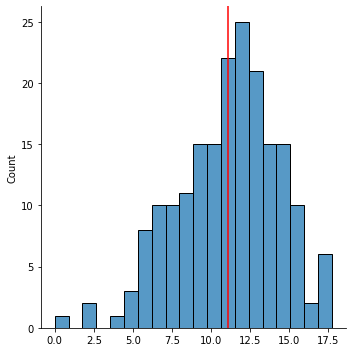

In [14]:
sns.displot(dis, bins=20)
plt.axvline(dis.mean(), color='r')

##### Add/remove per-atom energy offset

In [15]:
# structure = structures[0]
# atom_energy = {'O': 2.4, 'H': 1.2}

# structure.add_energy_offset(atom_energy)
# structure.total_energy

## Descriptor
Atomic environment descriptor

In [16]:
from jaxip.descriptors.acsf import ACSF, G2, G3, G9, CutoffFunction

In [17]:
# acsf = ACSF('Ne')
# cfn = CutoffFunction(3.0, cutoff_type='tanhu')
# acsf.add(G2(cfn, eta=1.00, r_shift=0.00), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.25), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.50), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.75), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=1.00), "Ne")

# acsf

In [18]:
acsf = ACSF('O')

cfn = CutoffFunction(12.0)
g2_1 = G2(cfn, 0.0, 0.001)
g2_2 = G2(cfn, 0.0, 0.01)
g3_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)
g9_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)

acsf.add(g2_1, 'H')
acsf.add(g2_2, 'H')
acsf.add(g3_1, 'H', 'H')
acsf.add(g3_1, 'H', 'O')
acsf.add(g9_1, 'H', 'O')
acsf

ACSF(element='O', size=5, r_cutoff=12.0)

In [19]:
val = acsf(s)
val[1]
# val.shape   

DeviceArray([6.2318468e+00, 4.6910887e+00, 2.6130967e-03, 2.2319485e-04,
             2.2319485e-04], dtype=float32)

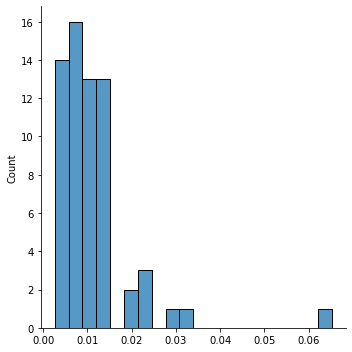

In [20]:
sns.displot(val[:, 2], bins=20)

#### Gradient

In [21]:
%time acsf.grad(s, 0, 3)

CPU times: user 4.18 s, sys: 17 ms, total: 4.2 s
Wall time: 4.1 s


DeviceArray([[-0.01492049,  0.02473107, -0.0606008 ]], dtype=float32)

In [22]:
# time [acsf.grad(structures[4], i, 0) for i in range(4)]

## Scaler
Descriptor scaler

In [23]:
from jaxip.descriptors.scaler import DescriptorScaler

In [24]:
scaler = DescriptorScaler(scale_type='scale_center')
# acsf = nnp.descriptor["H"]

for structure in tqdm(structures):
    x = acsf(structure)
    scaler.fit(x)

scaler

100%|██████████| 10/10 [00:00<00:00, 13.95it/s]


DescriptorScaler(scale_type='scale_center', scale_min=0.0, scale_max=1.0)

In [25]:
scaled_x = []
for structure in tqdm(structures):
    x = acsf(structure)
    scaled_x.append(scaler(x))

scaled_x = jnp.concatenate(scaled_x, axis=0)
scaled_x.shape

100%|██████████| 10/10 [00:00<00:00, 16.46it/s]


(640, 5)

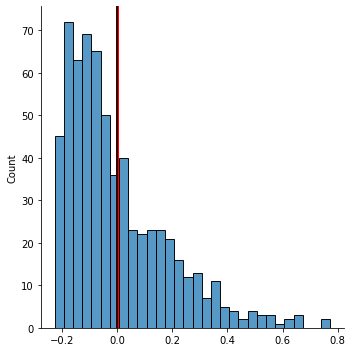

In [26]:
sx = scaled_x[:, 5]
sns.displot(sx, bins=30)
plt.axvline(sx.mean(), color='r', lw=3);
plt.axvline(0, color='k');

## Model

In [27]:
from jaxip.models.nn import NeuralNetworkModel
from jaxip.models.initializer import UniformInitializer
from flax import linen as nn

In [28]:
nn = NeuralNetworkModel(
    hidden_layers=((8, 't'), (8, 't')),
    kernel_initializer=UniformInitializer(weights_range=(-1, 1)),
    # param_dtype=jnp.float64,
)

In [29]:
rng = jax.random.PRNGKey(2022) # PRNG Key
x = jnp.ones(shape=(8, acsf.num_symmetry_functions)) # Dummy Input
params = nn.init(rng, x) # Initialize the parameters
jax.tree_map(lambda x: x.shape, params) # Check the parameters

FrozenDict({
    params: {
        layers_0: {
            bias: (8,),
            kernel: (5, 8),
        },
        layers_2: {
            bias: (8,),
            kernel: (8, 8),
        },
        layers_4: {
            bias: (1,),
            kernel: (8, 1),
        },
    },
})

In [30]:
eng = nn.apply(params, scaled_x[:, :])

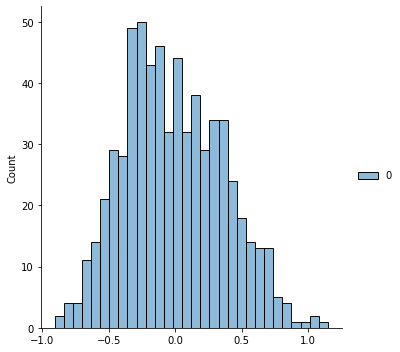

In [31]:
sns.displot(eng, bins=30);